# Counting dice with Computer Vision


![](https://user-images.githubusercontent.com/3716307/70001073-3ec5d000-1511-11ea-9b4f-42e14b6af1b7.png)

## SageMaker Ground-Truth

You'll shortly step through the process of setting up a SageMaker ground-truth labelling job, but first we need to upload our images to Amazon S3.

We have already loaded the images onto this SageMaker Notebook instance, and you can find them at `./data`.

Using the Amazon SageMaker SDK we can upload these images to the default bucket. See `session.upload_data` below.

In [1]:
import sagemaker

session = sagemaker.session.Session()
default_s3_bucket = 's3://{}'.format(session.default_bucket())
print('default_s3_bucket: {}'.format(default_s3_bucket))

default_s3_bucket: s3://sagemaker-us-east-1-431615879134


In [2]:
training_images = session.upload_data('./data', key_prefix='vegas-dice-images')
print("Bucket for ground-truth Labeling: {}/images/".format(training_images))

Bucket for ground-truth Labeling: s3://sagemaker-us-east-1-431615879134/vegas-dice-images/images/


You should now open the [AWS Management Console](https://console.aws.amazon.com/sagemaker/groundtruth?region=us-east-1#/labeling-jobs) and setup your SageMaker ground-truth labeling job.

## Exploritory Data Analysis

In this section we are going to download and explore the data. This is a dataset that has been labeled in ground-truth and contains the bounding boxes for the dice present in the picture from the training dataset

It is recommended at the beginning of any ML project to get well acquainted with the format and type of data that you are working with, on a qualitative and quantitative level

In [3]:
!pip install gluoncv --pre -q

You should consider upgrading via the '/home/ec2-user/anaconda3/envs/mxnet_p36/bin/python -m pip install --upgrade pip' command.


In [4]:
import glob
import json
import math
import os
import random
import time
import zipfile

import cv2
import gluoncv as gcv
import matplotlib.pyplot as plt
import mxnet as mx
import numpy as np

### Visualize the images

In [5]:
data_dir = 'data'
images_dir = os.path.join(data_dir, 'images')
train_images = glob.glob(images_dir + "/*")

In [6]:
print("We have {} images".format(len(train_images)))

We have 315 images


Let's see how they look like. We use matplotlib to plot 36 images from the dataset to get a feel for what they are

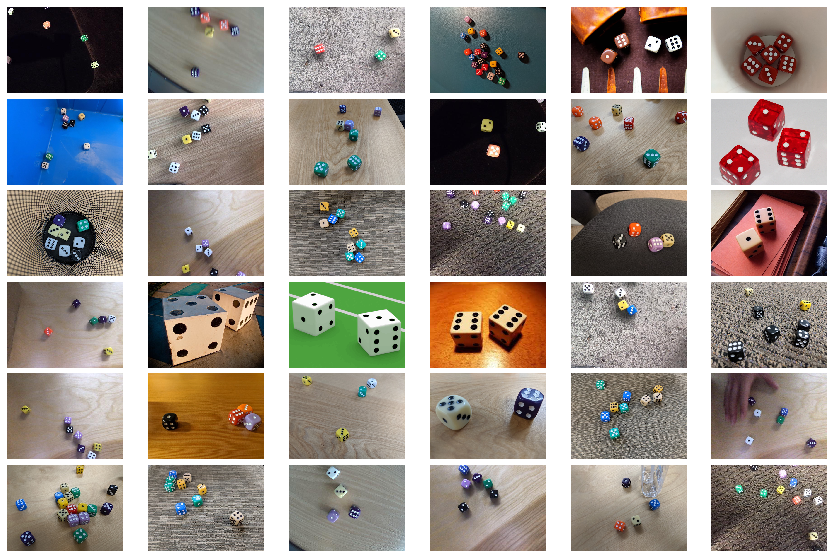

In [7]:
n_images = 36
cols = (int(math.sqrt(n_images)))
fig = plt.figure(figsize=(15,10))
for n, (image) in enumerate(np.random.choice(train_images,size=n_images,replace=False)):
    image = plt.imread(image)
    a = fig.add_subplot(np.ceil(n_images/float(cols)), cols, n + 1)
    plt.imshow(image)
    plt.axis('off')
plt.subplots_adjust(wspace=0.06, hspace=0.06)
plt.show()

### Bounding boxes

We've included the `output.manifest` file from our complete SageMaker GroundTruth labeling job on all images.

Let's dig in the info we have in the manifest file! On each image, there is one or more dice. We read this information from the `output.manifest` file.

In [8]:
image_info = []
with open(os.path.join(data_dir, 'manifest', 'output.manifest')) as f:
    lines = f.readlines()
    for line in lines:
        image_info.append(json.loads(line[:-1]))

For each image, we have the following information:

In [9]:
info = image_info[10]
task = 'dice-labeling'
info

{'source-ref': 's3://tdelteil-sagemaker-reinvent2019-worksop/dice/IMG_20191112_101245_1.jpg',
 'dice-labeling': {'annotations': [{'class_id': 3,
    'width': 61,
    'top': 72,
    'height': 63,
    'left': 230},
   {'class_id': 3, 'width': 69, 'top': 116, 'height': 65, 'left': 419},
   {'class_id': 4, 'width': 54, 'top': 16, 'height': 60, 'left': 133},
   {'class_id': 4, 'width': 54, 'top': 21, 'height': 57, 'left': 38},
   {'class_id': 5, 'width': 68, 'top': 166, 'height': 69, 'left': 105}],
  'image_size': [{'width': 512, 'depth': 3, 'height': 384}]},
 'dice-labeling-metadata': {'job-name': 'labeling-job/dice-labeling',
  'class-map': {'1': 'two',
   '0': 'one',
   '3': 'four',
   '2': 'three',
   '5': 'six',
   '4': 'five',
   '6': 'unclear'},
  'human-annotated': 'yes',
  'objects': [{'confidence': 0.09},
   {'confidence': 0.09},
   {'confidence': 0.09},
   {'confidence': 0.09},
   {'confidence': 0.09}],
  'creation-date': '2019-11-12T22:03:36.489415',
  'type': 'groundtruth/objec

We can access the name of the different classes corresponding to the class index as given by the SageMaker ground-truth labeling job

In [10]:
class_map = info[task+'-metadata']['class-map']
classes = [class_map[str(i)] for i in range(len(class_map))]
classes

['one', 'two', 'three', 'four', 'five', 'six', 'unclear']

We can read the data from this dictionnary to use it to draw a bounding box around the dice using the OpenCV library

In [11]:
info = image_info[random.randint(0, len(image_info)-1)]
image = plt.imread(os.path.join(images_dir, info['source-ref'].split('/')[-1]))

In [12]:
boxes = info['dice-labeling']['annotations']
for box in boxes:
    cv2.rectangle(image, (int(box['left']), int(box['top'])), (int(box['left']+box['width']), int(box['top']+box['height'])), (0,255,0), 3)
    cv2.putText(image, str(box['class_id']+1), (int(box['left']+box['width']), int(box['top']+box['height'])), 1, 3, (255,0,0), 3)

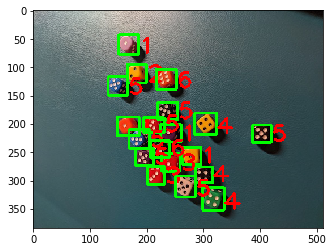

In [13]:
o = plt.imshow(image)

## Fine-tuning an object detection model

Now that we have explored the dataset, let's run a training job on SageMaker

In [14]:
import glob
import os
import re
import subprocess
import sys
import time
from time import gmtime, strftime

import boto3
import sagemaker
import numpy as np
from utils import get_execution_role

## 1) Running the job locally

It is always a good practice to run first the training job in local model in order to make sure that the training complete successfully, this allows much faster feedback cycle than waiting for the creation of remote instances

### Configuring the environment

In [15]:
s3_output_path = '{}/'.format(default_s3_bucket)
print("S3 bucket path: {}".format(s3_output_path))

S3 bucket path: s3://sagemaker-us-east-1-431615879134/


We first run it locally

In [16]:
instance_type = 'local' if mx.context.num_gpus() == 0 else 'local_gpu'
print(instance_type)

local_gpu


Make sure docker is setup properly

In [17]:
!/bin/bash ./setup.sh

The user has root access.
nvidia-docker2 already installed. We are good to go!
SageMaker instance route table setup is ok. We are good to go.
SageMaker instance routing for Docker is ok. We are good to go!


We get the SageMaker execution role

In [18]:
try:
    role = sagemaker.get_execution_role()
except:
    role = get_execution_role()

print("Using IAM role arn: {}".format(role))

Using IAM role arn: arn:aws:iam::431615879134:role/sagemaker-test-role


### Job definition

In [19]:
# create a descriptive job name 
job_name_prefix = 'hpo-dice-yolo'

Static hyperparameters

In [20]:
static_hyperparameters = {
    'epochs': 2
}

### Estimator

In [24]:
from sagemaker.mxnet.estimator import MXNet
estimator = MXNet(entry_point="src/train_yolo-opencv.py",
                  role=role,
                  instance_type="ml.p3.2xlarge",
                  instance_count=1,
                  output_path=s3_output_path,
                  framework_version="1.4.1",
                  py_version='py3',
                  base_job_name=job_name_prefix,
                  hyperparameters=static_hyperparameters
                 )

Let's first run in local mode to make sure it is running properly, then we can run it remotely

In [25]:
%%time

estimator.fit({"train": training_images})

2020-12-04 02:55:34 Starting - Starting the training job...
2020-12-04 02:55:36 Starting - Launching requested ML instances.........
2020-12-04 02:57:06 Starting - Preparing the instances for training......
2020-12-04 02:58:35 Downloading - Downloading input data
2020-12-04 02:58:35 Training - Downloading the training image...
2020-12-04 02:58:57 Training - Training image download completed. Training in progress..2020-12-04 02:58:58,621 sagemaker-containers INFO     Imported framework sagemaker_mxnet_container.training
2020-12-04 02:58:58,647 sagemaker_mxnet_container.training INFO     MXNet training environment: {'SM_HOSTS': '["algo-1"]', 'SM_NETWORK_INTERFACE_NAME': 'eth0', 'SM_HPS': '{"epochs":2}', 'SM_USER_ENTRY_POINT': 'train_yolo-opencv.py', 'SM_FRAMEWORK_PARAMS': '{}', 'SM_RESOURCE_CONFIG': '{"current_host":"algo-1","hosts":["algo-1"],"network_interface_name":"eth0"}', 'SM_INPUT_DATA_CONFIG': '{"train":{"RecordWrapperType":"None","S3DistributionType":"FullyReplicated","TrainingI

### 2) Hyperparameter Tuner job

We are going to run an hyper-parameter tuning job, it is using gaussian processes to estimate the best combination of parameters. Try picking some ranges based on what you know of ML and let the system finds the best candidates for you

We now pick a cloud instance a create a new estimator

In [26]:
static_hyperparameters = {
    'epochs' : 30
}

In [27]:
train_use_spot_instances = True
train_max_run = 3600
train_max_wait = 3600 if train_use_spot_instances else None

In [30]:
instance_type = "ml.p3.2xlarge"
estimator = MXNet(entry_point="src/train_yolo-opencv.py",
                  role=role,
                  instance_type=instance_type,
                  instance_count=1,
                  output_path=s3_output_path,
                  framework_version="1.4.1",
                  py_version='py3',
                  base_job_name=job_name_prefix,
                  hyperparameters=static_hyperparameters,
                  use_spot_instances=train_use_spot_instances,
                  max_run=train_max_run,  # seconds
                  max_wait=train_max_wait  # seconds
                 )

### Metrics 
We define the metric that we are going to track, we want to track:
- the current running validation Mean Average Precision: `run_validation_mAP`
- the final best validation Mean Average Precision: `validation_mAP`

<img src="https://www.pyimagesearch.com/wp-content/uploads/2016/09/iou_equation.png"  width=400>

In [31]:
metric_definitions = [
    {'Name': 'validation_mAP', 'Regex': 'best mAP ([-+]?[0-9]*[.]?[0-9]+([eE][-+]?[0-9]+)?)'},
    {'Name': 'run_validation_mAP', 'Regex': 'running mAP ([-+]?[0-9]*[.]?[0-9]+([eE][-+]?[0-9]+)?)'}]

### HPO job parameters

In [32]:
from sagemaker.tuner import IntegerParameter, CategoricalParameter, ContinuousParameter, HyperparameterTuner

# The hyperparameters we're going to tune
hyperparameter_ranges = {
    'lr': ContinuousParameter(0.0001, 0.002), # learning rate, how much should the model learn from the current iteration ( < 0.01 )
    'batch_size': IntegerParameter(2, 8), # batch size, how many pictures in each learning iteration (> 1)
    'lr_factor': ContinuousParameter(0.3, 1), # learning rate factor, How much to multiply the learning rate after 2/3 of trainign (0 < x < 1)
    'wd': ContinuousParameter(0.00001, 0.00005), # Weight decay: Regularization to force small weights ( < 0.001 )
    'class_factor': ContinuousParameter(2, 8), # Class factor: How much to weigh the importance of getting the right class vs finding objects (> 1)
    'model': CategoricalParameter(["yolo3_darknet53_coco", "yolo3_mobilenet1.0_coco"]),
}

We are running a total of 6 jobs, 2 in parallel. This is quite a small number to really appreciate the power of the bayesian sampling of the hyper parameters but given the time and budget constraint, it is an acceptable compromise

In [33]:
max_jobs = 6
max_parallel_jobs = 2

We create the tuner object which will `Maximize` the `validataion_mAP` metric across training runs by picking candidate parameter sets from the ranges provided

In [ ]:
%%time

tuner = HyperparameterTuner(estimator,
                            objective_metric_name='validation_mAP',
                            objective_type='Maximize',
                            hyperparameter_ranges=hyperparameter_ranges,
                            metric_definitions=metric_definitions,
                            max_jobs=max_jobs,
                            max_parallel_jobs=max_parallel_jobs,
                            base_tuning_job_name=job_name_prefix
                           )
tuner.fit({"train":training_images})

.............................................................................................................

In [ ]:
job_name = tuner.latest_tuning_job.job_name
print("Tuning job: %s" % job_name)

In [ ]:
print("You can monitor the progress of your jobs here: https://us-east-1.console.aws.amazon.com/sagemaker/home?region=us-east-1#/hyper-tuning-jobs/{}".format(job_name))

In [ ]:
!pygmentize src/train_yolo.py

**Continue after this point when at least one job as completed in the HPO job**

Now that you have a good handle on what happened, let's see if we can deploy the best model from our HPO job

In [ ]:
best_job = tuner.best_training_job()
tuner.best_training_job()

## Deployment

Deploy the best tuning job, with data capture enabled.  Enabling data capture is the first set for setting up a Model Monitor.  Data capture is enabled at enpoint configuration level for the Amazon SageMaker real-time endpoint. You can choose to capture the request payload, the response payload or both and captured data is stored in JSON format.

In [ ]:
estimator_best_job = estimator.attach(best_job, session)

### OPTIONAL - Deploy an already trained model

In [ ]:
#job = 'hpo-dice-yolo-201007-2010-003-fc930efc'
#estimator_best_job = estimator.attach(job, session)

We deploy the best tuning job on a cluster of one CPU instance

In [ ]:
%%time

from sagemaker.model_monitor import DataCaptureConfig

endpoint_name = 'dice-yolo-mxnet' + strftime("%Y-%m-%d-%H-%M-%S", gmtime())
print(endpoint_name)

deployed_model = estimator_best_job.deploy(initial_instance_count=1,
                                           instance_type='ml.m5.xlarge',
                                           endpoint_name=endpoint_name)


Predict bounding boxes

In [ ]:
x, image = gcv.data.transforms.presets.yolo.load_test('test.jpg', short=384)
output = deployed_model.predict(image)

Visualize the result

In [ ]:
cid = np.array(output['cid'])
scores = np.array(output['score'])
bbox = np.array(output['bbox'])

o = gcv.utils.viz.plot_bbox(image, bbox, scores, cid, class_names=classes)

## OPTIONAL - Compilation

We can compile the model using SageMaker neo for faster runtime on specific hardware platforms, in the cloud or on the edge

In [ ]:
compiled_model = estimator_best_job.compile_model('ml_c5', {'data' : (1, 3, 384, 512)}, s3_output_path, framework='mxnet', framework_version='1.4.1')

You can find the compiled model on s3 and refer to the [SageMaker documentation](https://docs.aws.amazon.com/sagemaker/latest/dg/neo.html) for the deployment instructions